In [1]:
import numpy as np
import pandas as pd
import os
import time
from astropy.io import fits

import matplotlib.pyplot as plt
plt.style.use('dark_background')
from astropy.visualization import make_lupton_rgb

from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

In [2]:
def make_plot(image, data):
    plt.figure(figsize=(8,5))
    print(data['COADD_OBJECT_ID'].values[0])
    title = '{:.3f}'.format(data['EINSTEIN_RADIUS'].values[0])
    plt.title(title)
    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
    plt.imshow(rgb, aspect='equal')
    #plt.xticks([], [])
    #plt.yticks([], [])
    plt.show()

1243683190


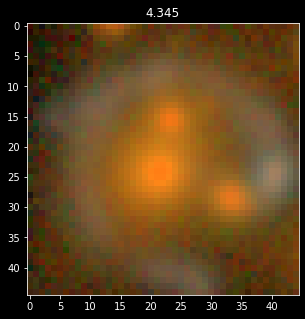

In [3]:
hdu_list = fits.open('Right_detectable_Jack_complete.fits')
images = hdu_list[1].data 
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

coadd_id = 1243683190
ind = data[data['COADD_OBJECT_ID'] == coadd_id].index
image = images[ind][0]
image_real = images[ind][0][0]
image_data = data.loc[ind]

make_plot(image, image_data)

In [4]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 5., 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -1, 'center_y': -1})
kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 1, 'center_y': 1})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}

In [5]:
# data specifics
background_rms = 7.  #  background noise per pixel 7.
exp_time = 90.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.2637  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = image_data['FWHM_WMEAN_G'].values[0]  # full width at half maximum of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

kwargs_data['image_data'] = image_real

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [6]:
lens_model_list = ['SIE', 'SHEAR']

source_model_list = ['SERSIC_ELLIPSE']

lens_light_model_list = ['SERSIC_ELLIPSE']

In [7]:
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
# if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-1.9951061237972292 reduced X^2 of best position
-1999.0963360448236 logL
2004 effective number of data points
[{'theta_E': 4.042404213493665, 'e1': -0.10913097157478192, 'e2': -0.06008001101181021, 'center_x': -0.19648306740414764, 'center_y': 0.13121722565280672}, {'gamma1': 0.09261539973528776, 'gamma2': 0.07536087942405416, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.5690424127523025, 'n_sersic': 3.378034826792657, 'e1': 0.3209915312628989, 'e2': 0.4984288637026804, 'center_x': 0.10562349306417756, 'center_y': -0.2216313109241}] source result
[{'amp': 1, 'R_sersic': 5.141054590987347, 'n_sersic': 0.5001484062289901, 'e1': 0.19655974584105856, 'e2': 0.03382302284874822, 'center_x': 1.1132702727744452, 'center_y': 0.03227698756272214}] lens light result
[] point source result
{} special param result
41.82266902923584 time used for  PSO


100%|███████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:00<00:00, 13.26it/s]

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
60.42886018753052 time taken for MCMC sampling


In [8]:
print(kwargs_result)
print(image_data['EINSTEIN_RADIUS'].values[0], image_data['EINSTEIN_RADIUS_ERR'].values[0])
print(image_data['TILENAME'].values[0])

{'kwargs_lens': [{'theta_E': 3.995639086253875, 'e1': -0.08138692322002351, 'e2': -0.05326353521040945, 'center_x': -0.008310059475907156, 'center_y': 0.11794293380486282}, {'gamma1': 0.06227195591278843, 'gamma2': 0.03981260031676047, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.6207977678481013, 'n_sersic': 3.3418648619795897, 'e1': 0.34871340258260697, 'e2': 0.46326923909723394, 'center_x': 0.34877353862089305, 'center_y': -0.07825498591784465}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 5.66458779219381, 'n_sersic': 0.6514540006438614, 'e1': 0.19608081217562623, 'e2': 0.003059609037504617, 'center_x': 1.2092990682754692, 'center_y': 0.04587715884074026}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}
4.34492058 0.68891632
DES0208-2706
